# Data EDA

In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
from typing import Dict, List, Tuple, Optional
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

In [2]:
# Import train csv
train = pd.read_csv('../sample_data/Train.csv')

# Display basic information about the dataset
print("Dataset shape:", train.shape)
print("\nColumn names:")
print(train.columns.tolist())
print("\nFirst few rows:")
print(train.head())

# Check data types
print("\nData types:")
print(train.dtypes)

Dataset shape: (16076, 14)

Column names:
['responseId', 'view_label', 'ID_enter', 'ID_exit', 'videos', 'video_time', 'datetimestamp_start', 'datetimestamp_end', 'date', 'signaling', 'congestion_enter_rating', 'congestion_exit_rating', 'time_segment_id', 'cycle_phase']

First few rows:
                responseId       view_label  \
0  zYkHaeOdB7XOnvgP3YW5kQs  Norman Niles #1   
1  NYsHaeCRLq-vnvgPjoXZqA0  Norman Niles #1   
2  A40HaYT8KNm7nvgPq8e12AU  Norman Niles #1   
3  EIsHaanDMK-vnvgPjoXZqA0  Norman Niles #1   
4  RYsHafSeMaqpmecP5vCV0AQ  Norman Niles #1   

                                            ID_enter  \
0  time_segment_0_Norman Niles #1_congestion_ente...   
1  time_segment_1_Norman Niles #1_congestion_ente...   
2  time_segment_2_Norman Niles #1_congestion_ente...   
3  time_segment_3_Norman Niles #1_congestion_ente...   
4  time_segment_4_Norman Niles #1_congestion_ente...   

                                             ID_exit  \
0  time_segment_0_Norman Niles #1_con

Congestion Enter Rating Distribution:
congestion_enter_rating
free flowing      10056
moderate delay     2328
light delay        1919
heavy delay        1773
Name: count, dtype: int64


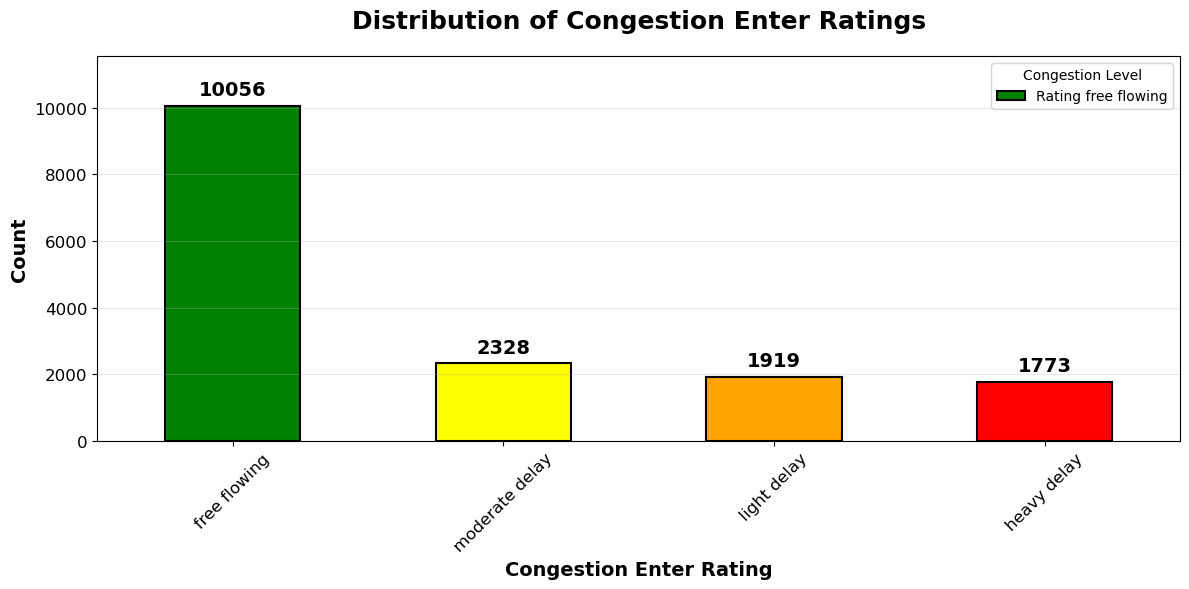


Sample video filenames:
0    normanniles1/normanniles1_2025-10-20-06-00-45.mp4
1    normanniles1/normanniles1_2025-10-20-06-01-45.mp4
2    normanniles1/normanniles1_2025-10-20-06-02-45.mp4
3    normanniles1/normanniles1_2025-10-20-06-03-45.mp4
4    normanniles1/normanniles1_2025-10-20-06-04-45.mp4
Name: videos, dtype: object

Hour range: 6 to 17


<Figure size 1400x800 with 0 Axes>

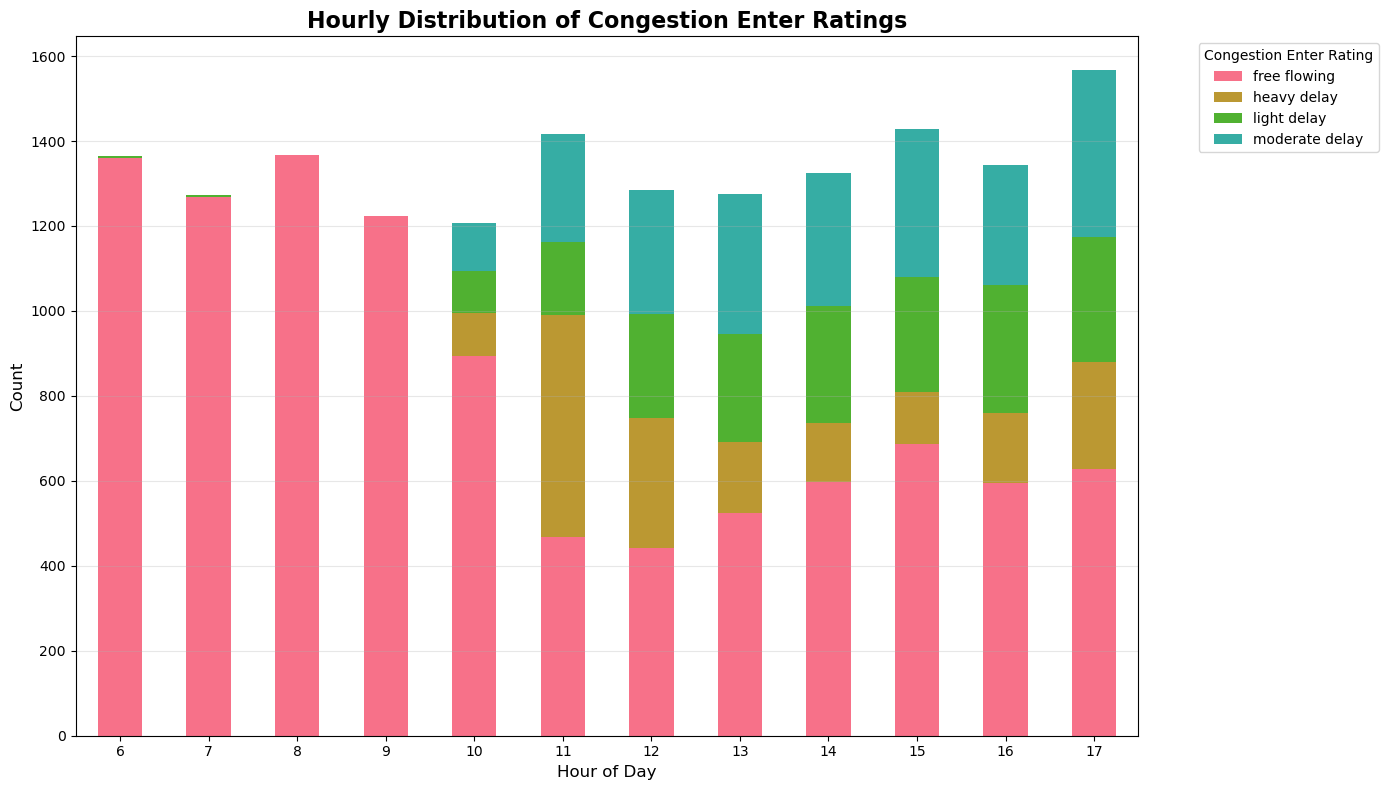

In [3]:
# Show hourly congestion Enter Rating

# Check the congestion enter rating distribution
print("Congestion Enter Rating Distribution:")
print(train['congestion_enter_rating'].value_counts())

# Bar chart for congestion enter rating distribution
plt.figure(figsize=(12, 6))
congestion_enter_counts = train['congestion_enter_rating'].value_counts()

# Define colors for different congestion levels
colors = ["green", "yellow", "orange", "red"]  
colors = colors[:len(congestion_enter_counts)]

# Create bar chart with different colors
ax = congestion_enter_counts.plot(kind='bar', color=colors, edgecolor='black', linewidth=1.5)
plt.title('Distribution of Congestion Enter Ratings', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Congestion Enter Rating', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add legend in top right
rating_labels = [f'Rating {rating}' for rating in congestion_enter_counts.index]
ax.legend(rating_labels, loc='upper right', fontsize=10, title='Congestion Level')

# Add value labels on bars with larger font
for i, v in enumerate(congestion_enter_counts.values):
    ax.text(i, v + max(congestion_enter_counts.values) * 0.02, str(v), 
            ha='center', va='bottom', fontweight='bold', fontsize=14)

# Set y-axis limit to provide space for labels
ax.set_ylim(0, max(congestion_enter_counts.values) * 1.15)

plt.tight_layout()
plt.show()

# Extract time information
if 'videos' in train.columns:
    print("\nSample video filenames:")
    print(train['videos'].head())
    
    # Extract hour from video filename timestamp
    train['timestamp'] = train['videos'].str.extract(r'(\d{4}-\d{2}-\d{2}-\d{2}-\d{2}-\d{2})')
    
    if train['timestamp'].notna().any():
        # Convert to datetime and extract hour
        train['datetime'] = pd.to_datetime(train['timestamp'], format='%Y-%m-%d-%H-%M-%S', errors='coerce')
        train['hour'] = train['datetime'].dt.hour
        
        # Create hourly analysis if we have time data
        if train['hour'].notna().any():
            print(f"\nHour range: {train['hour'].min()} to {train['hour'].max()}")
            
            # Hourly distribution of enter ratings
            plt.figure(figsize=(14, 8))
            
            # Create a pivot table for stacked bar chart
            hourly_data = train.groupby(['hour', 'congestion_enter_rating']).size().unstack(fill_value=0)
            
            # Create stacked bar chart
            hourly_data.plot(kind='bar', stacked=True, figsize=(14, 8))
            plt.title('Hourly Distribution of Congestion Enter Ratings', fontsize=16, fontweight='bold')
            plt.xlabel('Hour of Day', fontsize=12)
            plt.ylabel('Count', fontsize=12)
            plt.legend(title='Congestion Enter Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.xticks(rotation=0)
            plt.grid(axis='y', alpha=0.3)
            plt.tight_layout()
            plt.show()
        else:
            print("Could not extract hour information from timestamps")
    else:
        print("Could not parse timestamps from video filenames")

Congestion enter ratings have a high class imbalance with Free Flowing being the most common class. This may require special handling during model training to avoid bias towards the majority class.

There is also increased congestion from the 10th hour of the day, with congestion reaching maximum levels around the 11th and 12th hour of the day. In general, this is unusual as traffic is usually heaviest during morning and evening rush hours. Further investigation into the dataset's time distribution and potential anomalies is recommended.

Congestion Exit Rating Distribution:
congestion_exit_rating
free flowing      15353
moderate delay      283
light delay         241
heavy delay         199
Name: count, dtype: int64


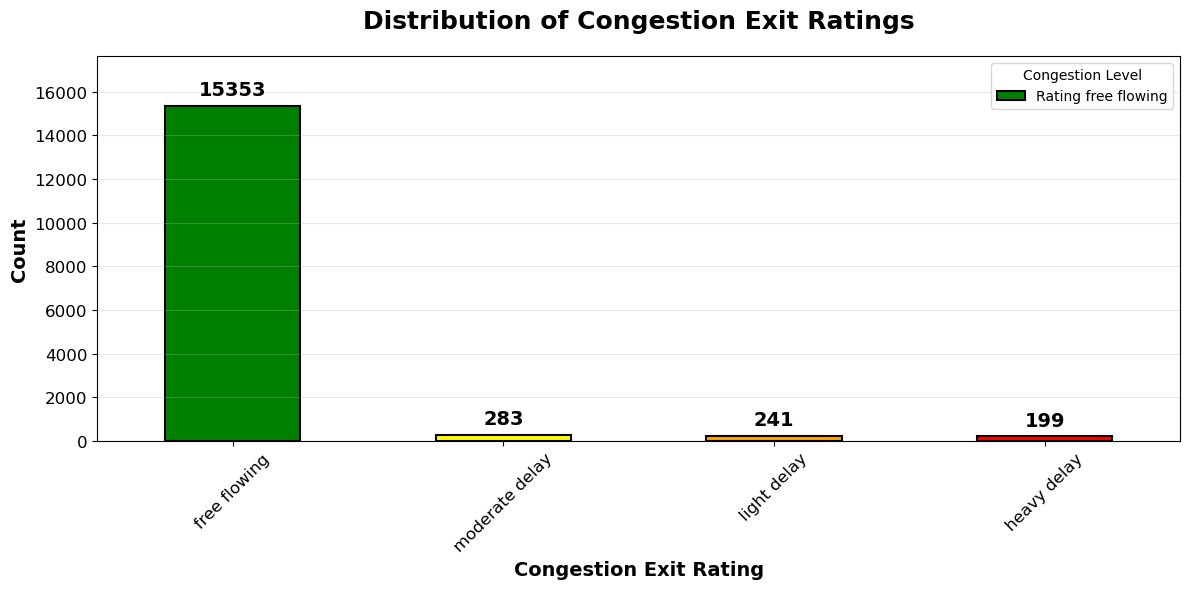

<Figure size 1400x800 with 0 Axes>

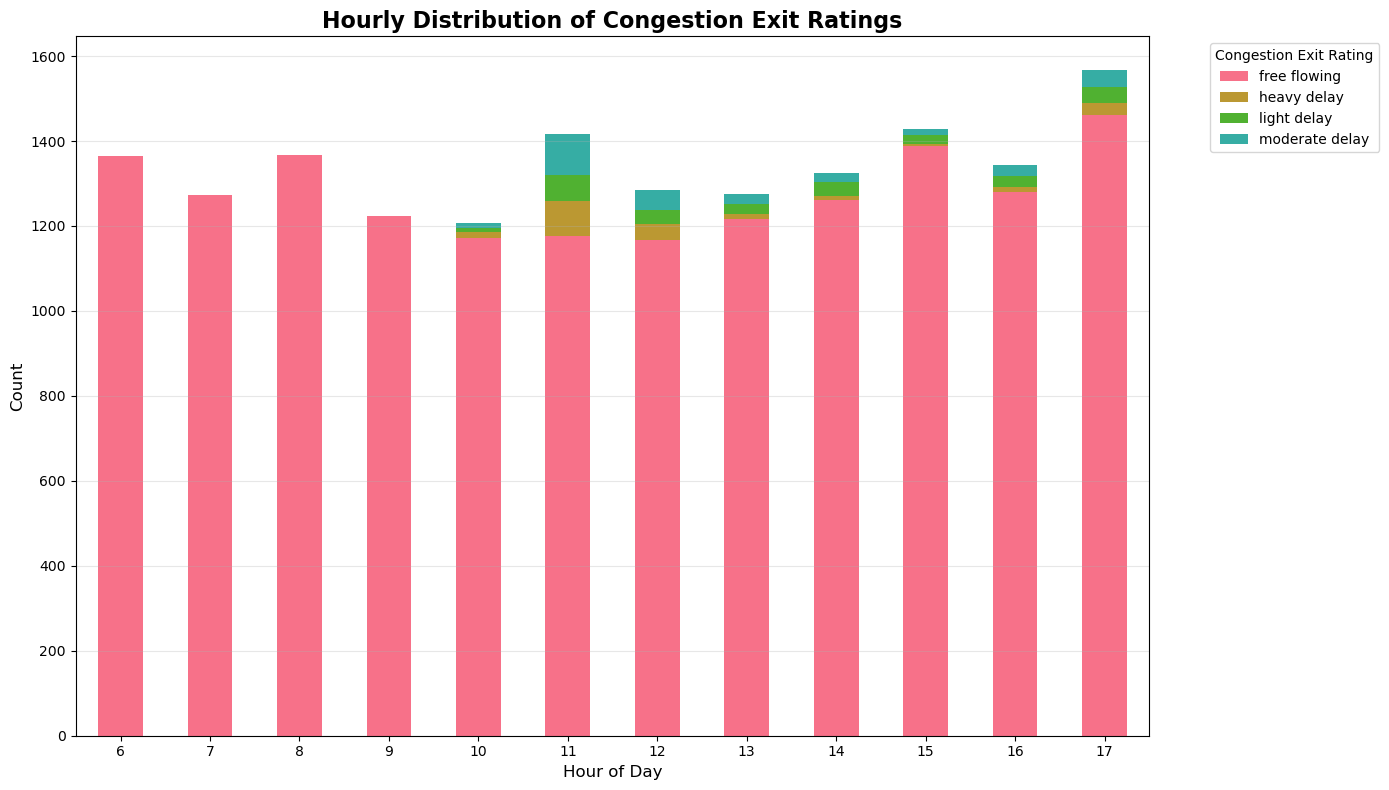

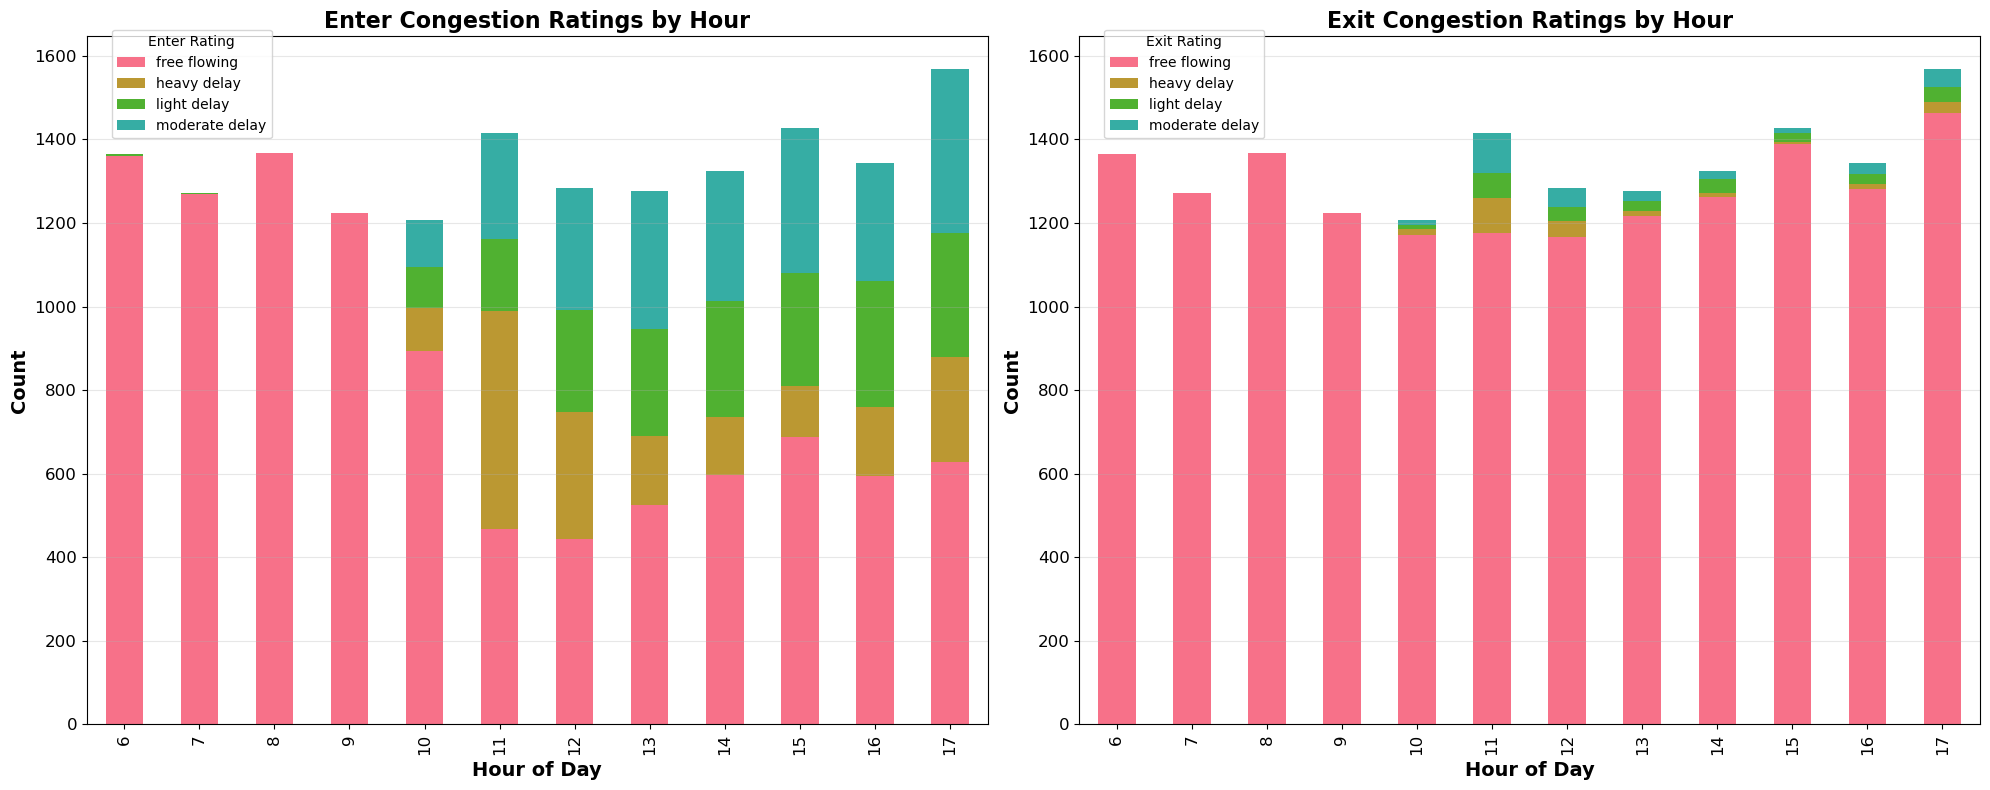

In [4]:
# Show hourly congestion Exit Rating

# Check the congestion exit rating distribution
print("Congestion Exit Rating Distribution:")
print(train['congestion_exit_rating'].value_counts())

# Bar chart for congestion exit rating distribution
plt.figure(figsize=(12, 6))
congestion_exit_counts = train['congestion_exit_rating'].value_counts()

# Define colors for different congestion levels
colors = ["green", "yellow", "orange", "red"]  
colors = colors[:len(congestion_exit_counts)]

# Create bar chart with different colors
ax = congestion_exit_counts.plot(kind='bar', color=colors, edgecolor='black', linewidth=1.5)
plt.title('Distribution of Congestion Exit Ratings', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Congestion Exit Rating', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add legend in top right
rating_labels = [f'Rating {rating}' for rating in congestion_exit_counts.index]
ax.legend(rating_labels, loc='upper right', fontsize=10, title='Congestion Level')

# Add value labels on bars with larger font
for i, v in enumerate(congestion_exit_counts.values):
    ax.text(i, v + max(congestion_exit_counts.values) * 0.02, str(v), 
            ha='center', va='bottom', fontweight='bold', fontsize=14)

# Set y-axis limit to provide space for labels
ax.set_ylim(0, max(congestion_exit_counts.values) * 1.15)

plt.tight_layout()
plt.show()


# Hourly distribution of exit ratings
plt.figure(figsize=(14, 8))

# Create a pivot table for stacked bar chart
hourly_exit_data = train.groupby(['hour', 'congestion_exit_rating']).size().unstack(fill_value=0)

# Create stacked bar chart
hourly_exit_data.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Hourly Distribution of Congestion Exit Ratings', fontsize=16, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Congestion Exit Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Compare Enter vs Exit ratings side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Enter ratings by hour
hourly_enter_data = train.groupby(['hour', 'congestion_enter_rating']).size().unstack(fill_value=0)
hourly_enter_data.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title('Enter Congestion Ratings by Hour', fontsize=16, fontweight='bold')
ax1.set_xlabel('Hour of Day', fontsize=14, fontweight='bold')
ax1.set_ylabel('Count', fontsize=14, fontweight='bold')
ax1.legend(title='Enter Rating', loc='upper left', bbox_to_anchor=(0.02, 1.02), fontsize=10)
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)

# Exit ratings by hour
hourly_exit_data.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title('Exit Congestion Ratings by Hour', fontsize=16, fontweight='bold')
ax2.set_xlabel('Hour of Day', fontsize=14, fontweight='bold')
ax2.set_ylabel('Count', fontsize=14, fontweight='bold')
ax2.legend(title='Exit Rating', loc='upper left', bbox_to_anchor=(0.02, 1.02), fontsize=10)
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

Congestion exit ratings have a high class imbalance with Free Flowing being the most common class. This may require special handling during model training to avoid bias towards the majority class. Similar to enter ratings, exit ratings also show increased congestion around the 11th and 12th hour of the day. However, congestion exit ratings appear to be less severe than enter ratings during these hours, indicating that some congestion may be alleviated before vehicles exit the intersection.

In [5]:
# Add corner label from view_label column by extracting the number
def extract_corner_label(view_label: str) -> Optional[int]:
    """Extract corner label number from view_label string."""
    try:
        # Handle format like "Norman Niles #1"
        return int(view_label.split('#')[-1])
    except (AttributeError, ValueError, IndexError):
        return None
    
train['corner_label'] = train['view_label'].apply(extract_corner_label)

print("\nSample corner labels extracted from view_label:")
print(train[['view_label', 'corner_label']].head())


Sample corner labels extracted from view_label:
        view_label  corner_label
0  Norman Niles #1             1
1  Norman Niles #1             1
2  Norman Niles #1             1
3  Norman Niles #1             1
4  Norman Niles #1             1


In [ ]:
# Check the distribution of corner labels
print("Corner label distribution:")
corner_distribution = train['corner_label'].value_counts().sort_index()
print(corner_distribution)

print(f"\nTotal records: {len(train)}")
print(f"Records with valid corner labels: {train['corner_label'].notna().sum()}")
print(f"Records with missing corner labels: {train['corner_label'].isna().sum()}")

# Show unique view_label values to see all corners
print(f"\nUnique view_label values:")
unique_views = train['view_label'].value_counts()
print(unique_views)

Corner label distribution:
corner_label
1    4019
2    4019
3    4019
4    4019
Name: count, dtype: int64

Total records: 16076
Records with valid corner labels: 16076
Records with missing corner labels: 0

Unique view_label values:
view_label
Norman Niles #1    4019
Norman Niles #2    4019
Norman Niles #3    4019
Norman Niles #4    4019
Name: count, dtype: int64


<Figure size 1400x800 with 0 Axes>

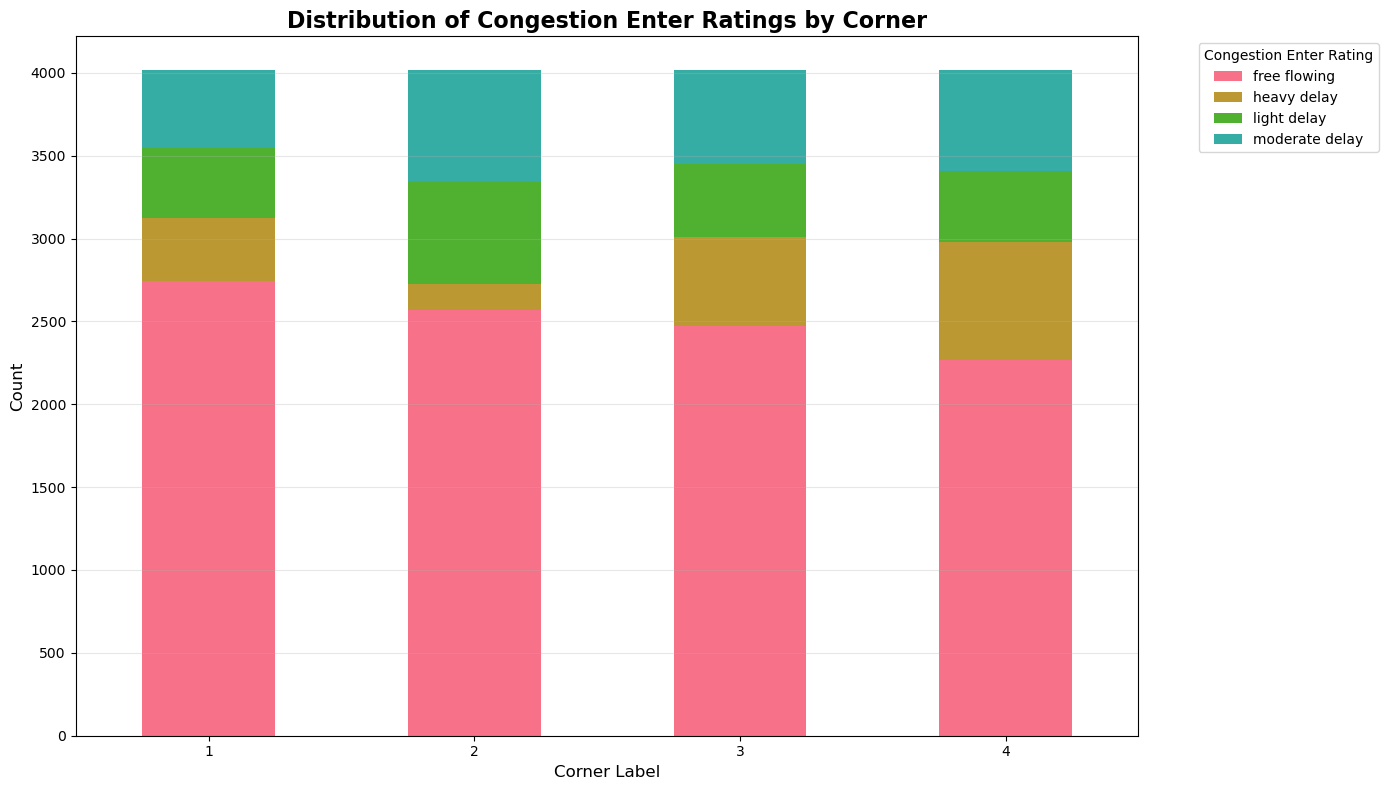

In [6]:
# Distribution of enter ratings by corner
plt.figure(figsize=(14, 8))
corner_enter_data = train.groupby(['corner_label', 'congestion_enter_rating']).size().unstack(fill_value=0)
corner_enter_data.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Distribution of Congestion Enter Ratings by Corner', fontsize=16, fontweight='bold')
plt.xlabel('Corner Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Congestion Enter Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Corner 4 has higher traffic as denoted by lower counts of free flowing vehicles compared to other corners. During prediction, footage from corner 4 might be a more important indicator of overall congestion levels.

Signalling columns: ['signaling']

signaling distribution:
signaling
none      8811
low       4074
medium    2594
high       597
Name: count, dtype: int64


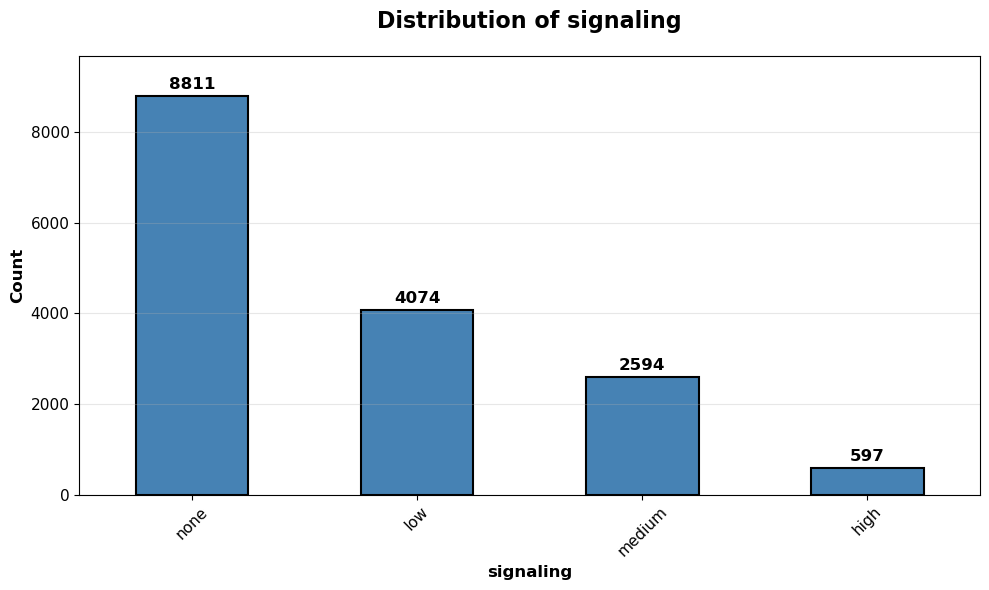

In [8]:
# Distribution of signalling values

signalling_columns = [col for col in train.columns if 'signal' in col.lower()]
print("Signalling columns:", signalling_columns)

for col in signalling_columns:
    print(f"\n{col} distribution:")
    signal_counts = train[col].value_counts()
    print(signal_counts)
    
    # Create bar chart for signalling distribution
    plt.figure(figsize=(10, 6))
    ax = signal_counts.plot(kind='bar', color='steelblue', edgecolor='black', linewidth=1.5)
    plt.title(f'Distribution of {col}', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel(col, fontsize=12, fontweight='bold')
    plt.ylabel('Count', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, fontsize=11)
    plt.yticks(fontsize=11)
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(signal_counts.values):
        ax.text(i, v + max(signal_counts.values) * 0.01, str(v), 
                ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    # Set y-axis limit to provide space for labels
    ax.set_ylim(0, max(signal_counts.values) * 1.1)
    
    plt.tight_layout()
    plt.show()


Cars do not singal when entering the roundabout 50% of the time and for almost 90% of the time the signaling is low or none. Lack of signaling could contribute to confusion and inefficiencies in traffic flow within the roundabout.

<Figure size 1400x800 with 0 Axes>

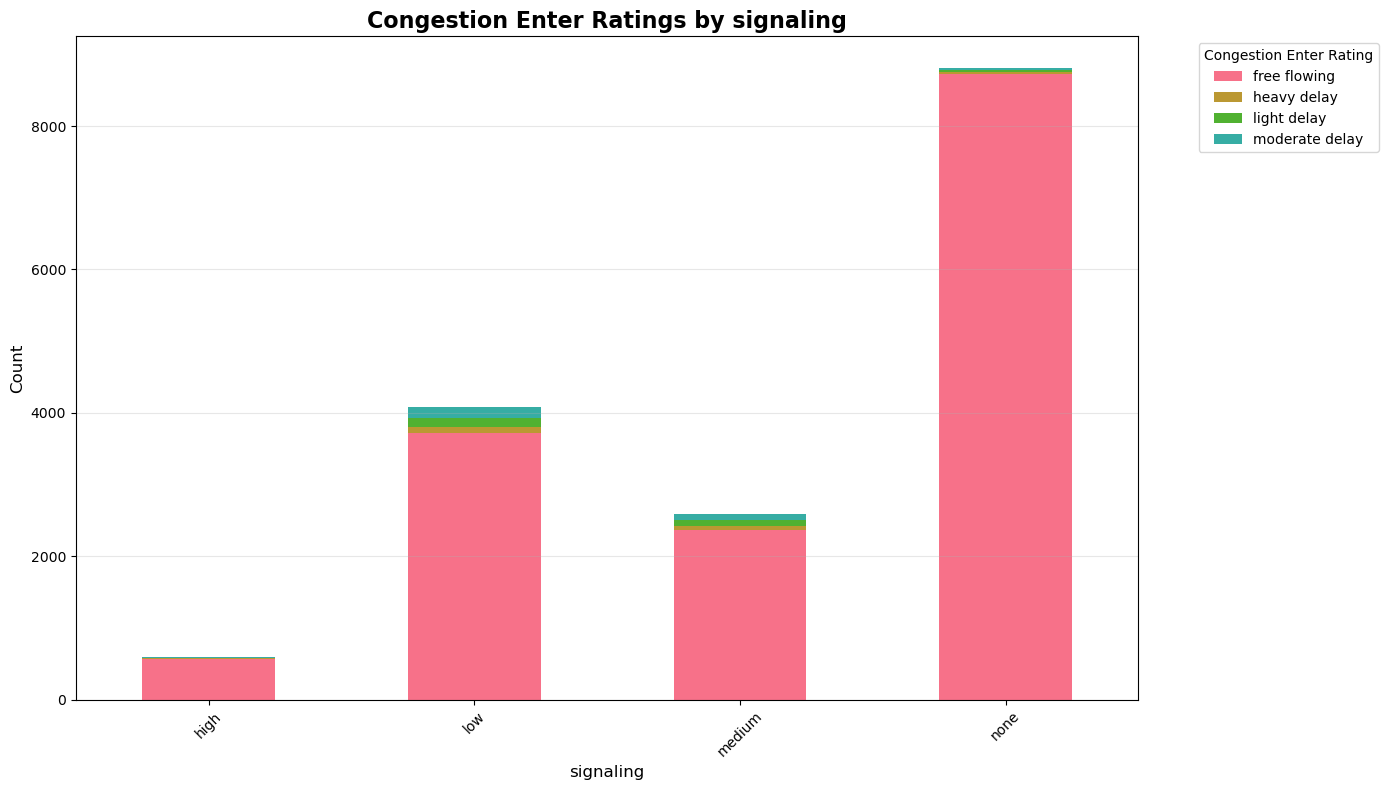

In [ ]:
# Signaling vs Congestion Analysis

for signal_col in signalling_columns:
    plt.figure(figsize=(14, 8))
    
    # Create a pivot table for stacked bar chart
    signal_congestion_data = train.groupby([signal_col, 'congestion_enter_rating']).size().unstack(fill_value=0)
    
    # Create stacked bar chart
    signal_congestion_data.plot(kind='bar', stacked=True, figsize=(14, 8))
    plt.title(f'Congestion Enter Ratings by {signal_col}', fontsize=16, fontweight='bold')
    plt.xlabel(signal_col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend(title='Congestion Enter Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

<Figure size 1400x800 with 0 Axes>

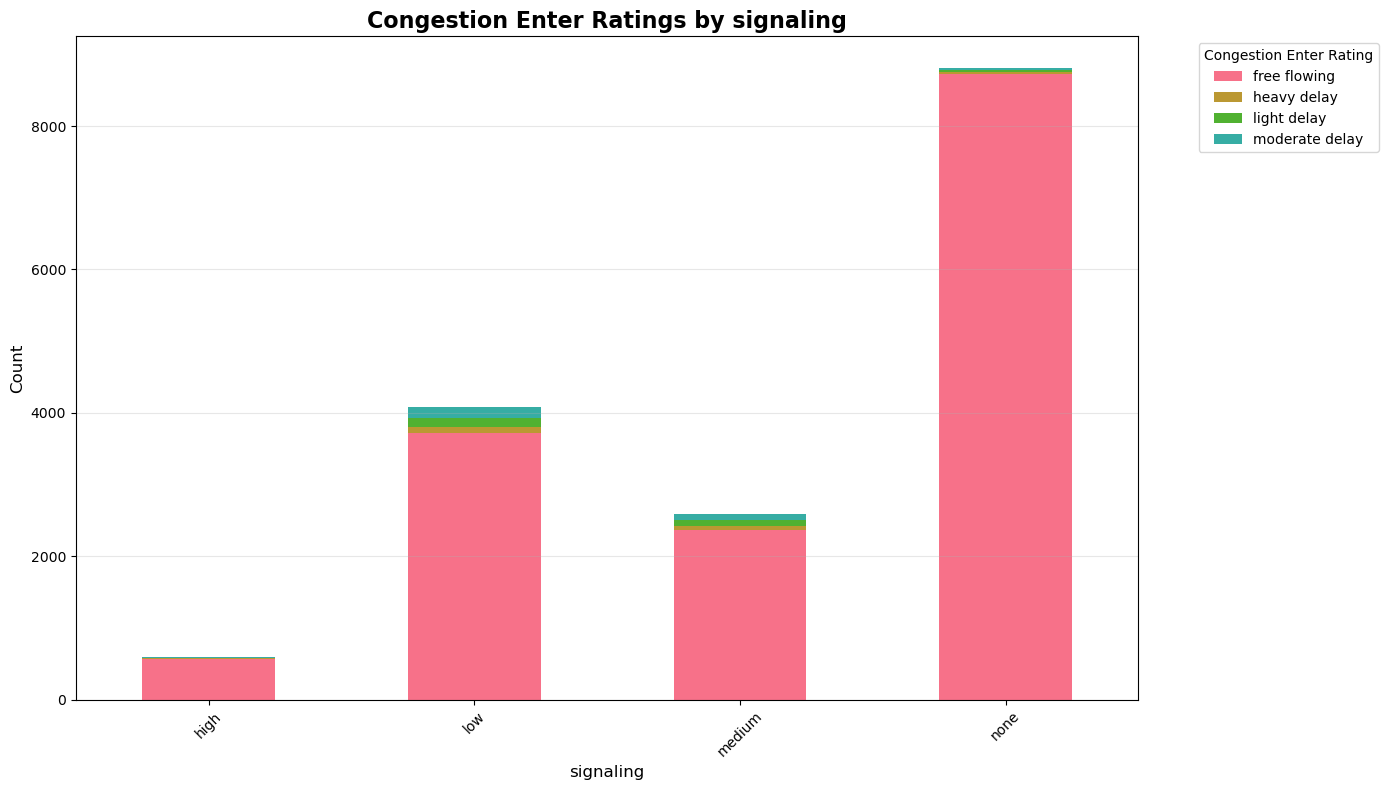

In [12]:
# Signaling vs Congestion Analysis

for signal_col in signalling_columns:
    plt.figure(figsize=(14, 8))
    
    # Create a pivot table for stacked bar chart
    signal_congestion_data = train.groupby([signal_col, 'congestion_exit_rating']).size().unstack(fill_value=0)
    
    # Create stacked bar chart
    signal_congestion_data.plot(kind='bar', stacked=True, figsize=(14, 8))
    plt.title(f'Congestion Enter Ratings by {signal_col}', fontsize=16, fontweight='bold')
    plt.xlabel(signal_col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend(title='Congestion Enter Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

Due to the class imbalance there are no clear trends between signaling and congestion levels. It might be beneficial to collect more balanced data or use techniques to address class imbalance during model training.

## 🕐 **TRAINING DATA STRUCTURE FOR 5-MINUTE FORECASTING**

Based on the Zindi challenge requirements and the video timestamps, here's how the training data should be structured:

### **Timeline Structure:**
```
[Video at T] → [2-min embargo] → [Target at T+7 minutes]
```

### **Key Insights from Data:**
- **Video Timestamps**: 1-minute intervals (06:00:45, 06:01:45, 06:02:45, etc.)
- **4 Camera Views**: Norman Niles #1, #2, #3, #4 (different corners)
- **Forecasting Task**: Predict congestion 5 minutes ahead with 2-minute lag

### **Data Structure Explanation:**

| Component | Description | Example |
|-----------|-------------|---------|
| **Input Features** | Video at timestamp T | Video at 06:00:45 |
| **Embargo Period** | 2-minute real-world lag | 06:00:45 → 06:02:45 |
| **Prediction Target** | Congestion at T+7min total | Target: congestion at 06:07:45 |
| **Forecast Horizon** | 5-minute prediction window | 06:02:45 → 06:07:45 |

### **Training Example:**
- **Features**: Video features from `06:00:45`
- **Target**: `congestion_enter_rating` and `congestion_exit_rating` at `06:07:45`
- This allows the model to learn: *"Given traffic patterns at 6:00:45, predict congestion at 6:07:45"*